<a href="https://colab.research.google.com/github/jullee96/getKosdaqBizList/blob/main/getBizData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## dart API를 이용해 코스닥 상장사의 필요정보 불러오기
---

- 사이트 : https://opendart.fss.or.kr/
- 필요형식

<br>


|회사이름|주식이름|회사영문이름|법인등록번호|대표명|전화번호| 
|----|----|------|--------|---|----|
|(주)삼에스코리아|3S|3S KOREA CO., LTD|1101110746474|김세완|02-896-9474|
|에이피에스홀딩스(주)|APS홀딩스|APS Holdings Corporation|1101111315286|정기로|031-776-1800|


<br>

### **dart API 데이터 제공 형식**

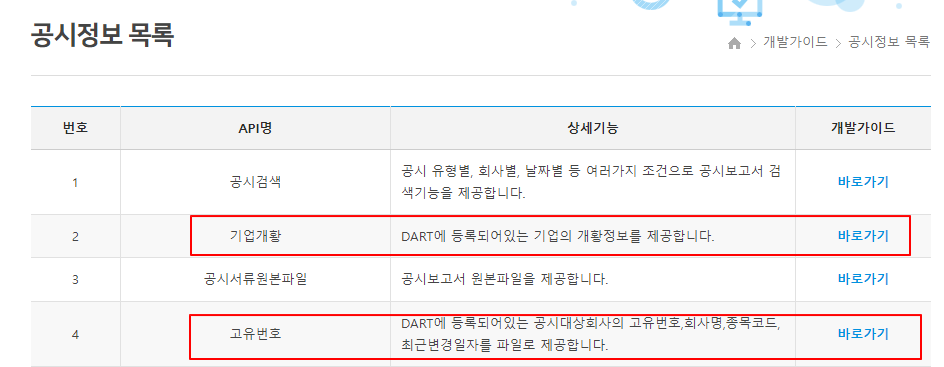

-> 필요 정보는 개업개황 정보에 존재하나 api에서 기업개황 정보는 1개씩 요청할수 있음 > 이때 요청 단위는 기업 고유번호를 key로 요청가능

<br>

#### **작업 순서** 
```
1) 고유번호 리스트 전체 받아오기
2) 고유번호 리스트를 통해 기업 개황정보리스트 구축
 2-1) 고유번호 리스트 정보가 95,272건으로 하루 api 요청 건수를 초과 
      -> 코스닥 상장사 리스트(kosdaqList)와 inner join 하여 불필요한 요청 건수 줄이기
 2-2) join 된 리스트로 기업개황 요청
3) 결과 데이터 엑셀형식으로 저장

```


In [23]:
# import 라이브러리
import requests
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from tqdm import notebook

import json
from pandas import json_normalize
import xml.etree.ElementTree as Xet
import pandas as pd
import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

## 1. 고유번호 데이터 불러오기
- 예시 : https://opendart.fss.or.kr/api/company.json?crtfc_key=34917fd862a8579675125e971a4145c42907b9eb&corp_code=01313895

In [ ]:
# dart 인증키 crtfc_key : 일 20,000건 요청 가능
crtfc_key = "{your API key}"
url = f'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={crtfc_key}'
with urlopen(url) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('corp_num')

### xml -> *csv* : corpCode.csv에 상장사 데이터 정보 저장 (코스닥, 유한, 코스피.. 모두)

- 컬럼 스키마
  - corp_code
  - corp_name
  - modify_date

In [ ]:
cols= ['corp_code', 'corp_name','modify_date']
rows = []

# Parsing the XML file
xmlparse = Xet.parse('corp_num/CORPCODE.xml')
root = xmlparse.getroot()
for i in root:
    corp_code = i.find("corp_code").text
    corp_name = i.find("corp_name").text
    modify_date = i.find("modify_date").text
  
    rows.append({"corp_code": corp_code,
                 "corp_name": corp_name,
                 "modify_date": modify_date})
  
df = pd.DataFrame(rows, columns=cols)
  
# Writing dataframe to csv
df.to_csv('corpCode.csv')


### load_data func 정의
: 기업개황 정보 불러오기 > dart에서 1건씩만 제공

- 호출 형식 : load_data('company','{corp_code}')

In [ ]:
def load_data(**kwargs):
    corp_code = kwargs['corp_code']
    
    if kwargs['request'] == 'company':
        
        # 기업개황 요청 url
        url = 'https://opendart.fss.or.kr/api/company.json?crtfc_key='+crtfc_key+'&corp_code='+corp_code
        
        # HTTP requests
        r = requests.get(url,verify=False)
        
        # json형식으로 받기
        company_data = r.json()
        
        # 기업개황 정보 반환
        return company_data

In [ ]:
# request 테스트 > message : '정상' 이면 OK
data = load_data(request='company', corp_code='00426208')
data

{'status': '000',
 'message': '정상',
 'corp_code': '00426208',
 'corp_name': '한국전자화학주식회사',
 'corp_name_eng': '',
 'stock_name': '한국전자화학',
 'stock_code': '',
 'ceo_nm': '이의륭',
 'corp_cls': 'E',
 'jurir_no': '1101111080920',
 'bizr_no': '2118604987',
 'adres': '서울특별시 강남구 논현1동 영풍빌딩',
 'hm_url': '',
 'ir_url': '',
 'phn_no': '02-519-3671',
 'fax_no': '02-549-8245',
 'induty_code': '20119',
 'est_dt': '19941001',
 'acc_mt': '12'}

In [ ]:
corpCodeList = pd.read_csv('corpCode.csv', dtype={'corp_code' : str}, sep=',', encoding="UTF-8" , na_filter = False, index_col=0)
corpCodeList[:5]

,corp_code,corp_name,modify_date
0,00434003,다코,20170630
1,00434456,일산약품,20170630
2,00430964,굿앤엘에스,20170630
3,00432403,한라판지,20170630
4,00388953,크레디피아제이십오차유동화전문회사,20170630


## 2. 고유번호 리스트를 통해 기업 개황정보리스트 구축

### 2-1 코스닥 상장사 리스트(kosdaqList)와 inner join 하여 불필요한 요청 건수 줄이기
#### 코스닥 상장사 리스트 파일 불러오기
- 정보수집 : https://kind.krx.co.kr/corpgeneral/corpList.do?method=loadInitPage

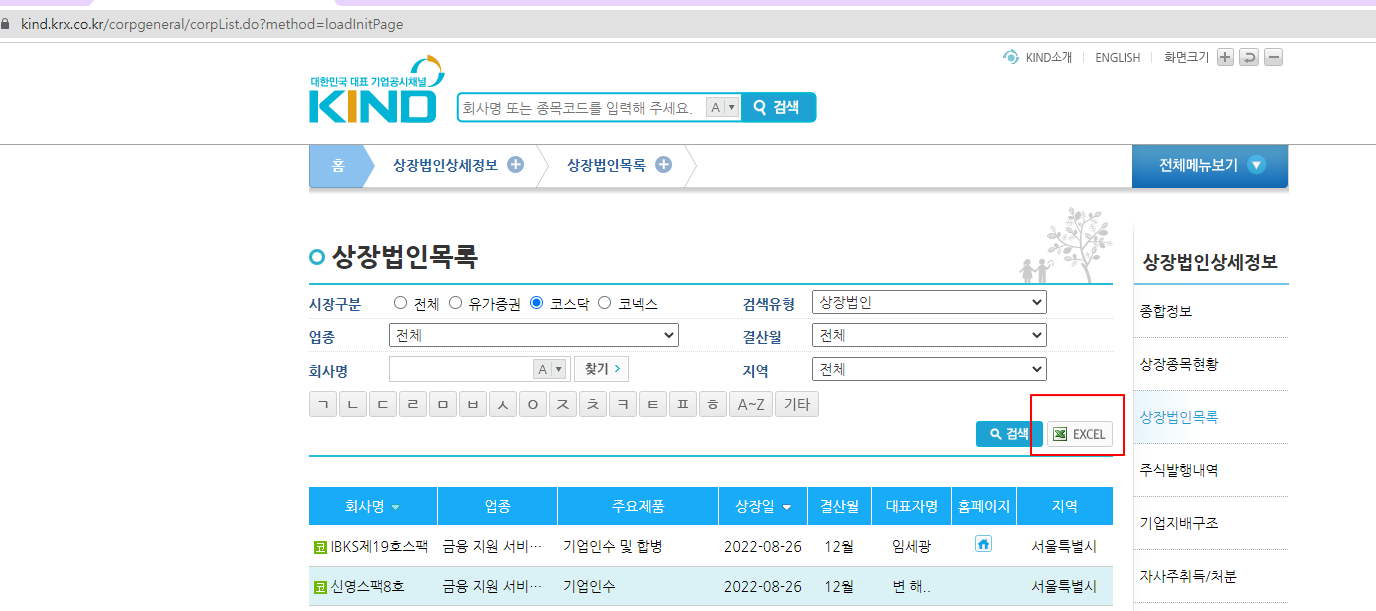

In [ ]:
kosdaqList = pd.read_csv('kosdaqList.csv', sep=',', encoding="UTF-8" , na_filter = False )
display(kosdaqList.head())
print(kosdaqList.shape)

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,IBKS제19호스팩,426550,금융 지원 서비스업,기업인수 및 합병,2022-08-26,12월,임세광,http://www.ibks.com,서울특별시
1,신영스팩8호,430220,금융 지원 서비스업,기업인수,2022-08-26,12월,변 해 봉,,서울특별시
2,대성하이텍,129920,특수 목적용 기계 제조업,"정밀부품, 스위스턴 자동선반, 컴팩트 머시닝센터",2022-08-22,12월,"최우각, 최호형",http:///www.topdsht.com/,대구광역시
3,에이치와이티씨,148930,기타 금속 가공제품 제조업,2차전지 장비 초정밀 부품,2022-08-09,12월,조동석,http://www.hyseoul.com,경기도
4,새빗켐,107600,기타 화학제품 제조업,"폐전지재활용소재, 폐산재활용",2022-08-04,12월,박민규,http://www.sebitchem.com,경상북도


(1577, 9)


In [ ]:
# 회사명 컬럼으로 join 하기 위해 컬럼명 변경 : 회사명 -> corp_name
kosdaqList = kosdaqList.rename(columns={'회사명': 'corp_name'})

In [ ]:
# 불필요한 컬럼 삭제
kosdaqList = kosdaqList.drop(columns=['업종','주요제품','상장일','결산월','대표자명','홈페이지','지역'],axis=1)

In [ ]:
kosdaqList

,corp_name,종목코드
0,IBKS제19호스팩,426550
1,신영스팩8호,430220
2,대성하이텍,129920
3,에이치와이티씨,148930
4,새빗켐,107600
...,...,...
1572,하이록코리아,13030
1573,SBI인베스트먼트,19550
1574,리더스 기술투자,19570
1575,엠벤처투자,19590


In [ ]:
# kosdaqList join corpCodeList : k_list
# 행 갯수가 1577 가 아닌 이유는 동일한 이름의 유한정보 상장사는  걸러지지 않아 행갯수가 1919개 > 처리 예정
k_list = pd.merge(kosdaqList,corpCodeList ,how='inner',on='corp_name')
display(k_list.head())
print(k_list.shape)

,corp_name,종목코드,corp_code,modify_date
0,신영스팩8호,430220,01656374,20220826
1,대성하이텍,129920,01160859,20170630
2,대성하이텍,129920,00577335,20220822
3,에이치와이티씨,148930,00885906,20220809
4,새빗켐,107600,00862880,20220804


(1919, 4)


### 2-2 join 된 리스트로 기업개황 요청
이중에 코스닥 상장사만 추리기(유한 정보도 중복되는 경우가 있음)

In [35]:
# 다소 시간이 소요됨 20~30분 
kosdaq = []
for i, el in  notebook.tqdm(enumerate(k_list['corp_code'] )): 
    tmp = load_data(request='company', corp_code=el)
    if tmp['corp_cls'] == 'K' :
      kosdaq.append(tmp)

0it [00:00, ?it/s]

In [24]:
# kosdaq은 json 형식의 리스트라 이를 dataframe 형식으로 변경
df = json_normalize(kosdaq) 

In [25]:
# df : 컬럼 리스트
df.columns

Index(['status', 'message', 'corp_code', 'corp_name', 'corp_name_eng',
       'stock_name', 'stock_code', 'ceo_nm', 'corp_cls', 'jurir_no', 'bizr_no',
       'adres', 'hm_url', 'ir_url', 'phn_no', 'fax_no', 'induty_code',
       'est_dt', 'acc_mt'],
      dtype='object')

In [26]:
# 불필요한 데이터 제거
df = df.drop(columns=['status','message'], axis=1)

In [27]:
df.head()

,corp_code,corp_name,corp_name_eng,stock_name,stock_code,ceo_nm,corp_cls,jurir_no,bizr_no,adres,hm_url,ir_url,phn_no,fax_no,induty_code,est_dt,acc_mt
0,01656374,신영해피투모로우제8호기업인수목적 주식회사,Shinyoung HappyTomorrow No.8 Special Purpose A...,신영스팩8호,430220,변 해 봉,K,1101118282032,3388102654,"서울특별시 영등포구 국제금융로8길 16, 5층(여의도동, 신영증권 빌딩)",-,,02-2004-9452,02-2004-9298,66199,20220427,12
1,00577335,(주)대성하이텍,"Daesung Hi-Tech Co., Ltd.",대성하이텍,129920,"최우각, 최호형",K,1701110205600,5038152160,"대구광역시 달성군 현풍면 테크노대로2길 10 (중리, (주)대성하이텍)",/www.topdsht.com/,,053-608-3600,053-592-6559,29223,20011012,12
2,00885906,(주)에이치와이티씨,"HYTC CO., LTD",에이치와이티씨,148930,조동석,K,1101113364372,1138602327,경기도 군포시 산본로101번길 9-14,www.hyseoul.com,,031-8068-8099,031-429-8572,25924,20051221,12
3,00862880,(주)새빗켐,"Sebitchem Co., LTD",새빗켐,107600,박민규,K,1713110007259,5108110800,경상북도 김천시 공단로 98,www.sebitchem.com,,054-431-3586,054-432-4238,2049,20010620,12
4,01663639,유안타제9호기업인수목적 주식회사,Yuanta 9 SPECIAL PURPOSE ACQUISITION COMPANY,유안타제9호스팩,430700,현승철,K,1101118289856,8758702418,서울특별시 중구 을지로 76,,,02-3770-2000,,66199,20220504,12


 ## 3. 결과 데이터 엑셀형식으로 저장

In [28]:
# 결과를 담을 dataframe 생성
result = pd.DataFrame()

In [29]:
# df에서 필요한 정보만 담기
result = df[['corp_name','stock_name','corp_name_eng','jurir_no','ceo_nm','phn_no']]
result.head()

,corp_name,stock_name,corp_name_eng,jurir_no,ceo_nm,phn_no
0,신영해피투모로우제8호기업인수목적 주식회사,신영스팩8호,Shinyoung HappyTomorrow No.8 Special Purpose A...,1101118282032,변 해 봉,02-2004-9452
1,(주)대성하이텍,대성하이텍,"Daesung Hi-Tech Co., Ltd.",1701110205600,"최우각, 최호형",053-608-3600
2,(주)에이치와이티씨,에이치와이티씨,"HYTC CO., LTD",1101113364372,조동석,031-8068-8099
3,(주)새빗켐,새빗켐,"Sebitchem Co., LTD",1713110007259,박민규,054-431-3586
4,유안타제9호기업인수목적 주식회사,유안타제9호스팩,Yuanta 9 SPECIAL PURPOSE ACQUISITION COMPANY,1101118289856,현승철,02-3770-2000


In [30]:
# stock_name 기준으로 sorting 한 결과 > result_sortby_sm
result_sortby_sm = result.sort_values('stock_name').reset_index()
result_sortby_sm.head()

,index,corp_name,stock_name,corp_name_eng,jurir_no,ceo_nm,phn_no
0,1195,(주)삼에스코리아,3S,"3S KOREA CO., LTD",1101110746474,김세완,02-896-9474
1,1243,에이피에스홀딩스(주),APS홀딩스,APS Holdings Corporation,1101111315286,정기로,031-776-1800
2,474,에이피시스템(주),AP시스템,Advanced Process Systems Corporation,1348110400341,김영주,031-379-2700
3,540,에이피위성(주),AP위성,Asia Pacific Satellite lnc.,1101114531045,류장수,02-2026-7800
4,1460,(주)비엔지티,BNGT,"BNGT CO.,LTD.",1753110000126,조상환,02-3412-8777


In [31]:
result_sortby_sm.drop('index', axis=1, inplace=True)

In [32]:
result_sortby_sm.head()

,corp_name,stock_name,corp_name_eng,jurir_no,ceo_nm,phn_no
0,(주)삼에스코리아,3S,"3S KOREA CO., LTD",1101110746474,김세완,02-896-9474
1,에이피에스홀딩스(주),APS홀딩스,APS Holdings Corporation,1101111315286,정기로,031-776-1800
2,에이피시스템(주),AP시스템,Advanced Process Systems Corporation,1348110400341,김영주,031-379-2700
3,에이피위성(주),AP위성,Asia Pacific Satellite lnc.,1101114531045,류장수,02-2026-7800
4,(주)비엔지티,BNGT,"BNGT CO.,LTD.",1753110000126,조상환,02-3412-8777


In [33]:
# excel 형식으로 저장하기 
result_sortby_sm.to_excel('kosdaq.xlsx')